Signal Power: 0.112847 V²
Noise Power: 0.288770 V²
SNR: -4.08 dB


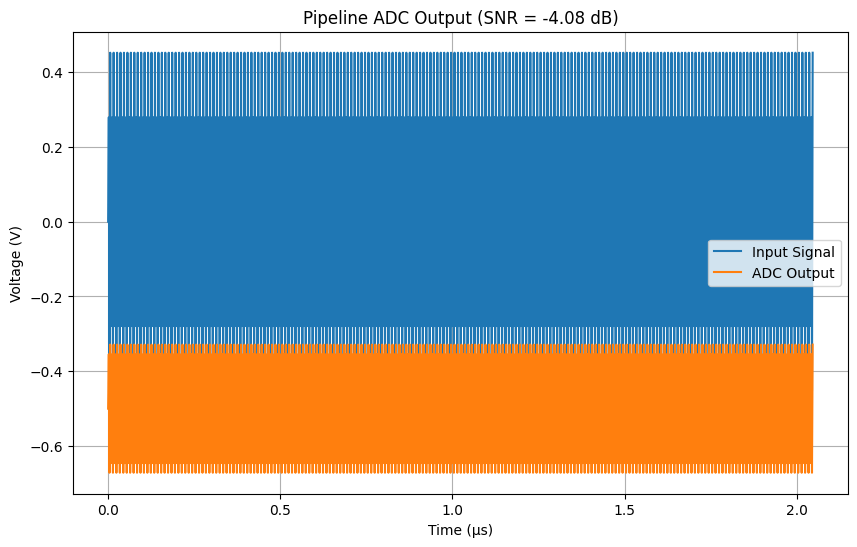

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)

# Input signal
A = Vfs / 2 * 0.95  # 0.475 V
x = A * np.sin(2 * np.pi * f_in * t)

# MDAC stage
def mdac_stage(v_in, v_ref=1.0):
    thresholds = [-v_ref/4, v_ref/4]
    if v_in < thresholds[0]:
        d = -1
        v_res = 4 * (v_in + v_ref/2)
    elif v_in < thresholds[1]:
        d = 0
        v_res = 4 * v_in
    else:
        d = 1
        v_res = 4 * (v_in - v_ref/2)
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC
def pipeline_adc(x, v_ref=1.0):
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d_stage[i], v_res[i] = mdac_stage(residue[i], v_ref)
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))  # Prevent negative shifts
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Simulate
adc_output, digital_outputs = pipeline_adc(x, Vfs)

# SNR
signal_power = np.mean(x ** 2)
quant_error = x - adc_output
noise_power = np.mean(quant_error ** 2)
snr = 10 * np.log10(signal_power / noise_power)

# Output
print(f"Signal Power: {signal_power:.6f} V²")
print(f"Noise Power: {noise_power:.6f} V²")
print(f"SNR: {snr:.2f} dB")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t * 1e6, x, label="Input Signal")
plt.plot(t * 1e6, adc_output, label="ADC Output")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (V)")
plt.title(f"Pipeline ADC Output (SNR = {snr:.2f} dB)")
plt.legend()
plt.grid()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Base Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
A = Vfs / 2 * 0.95  # 0.475 V
x = A * np.sin(2 * np.pi * f_in * t)

# MDAC Stage with Errors
def mdac_stage(v_in, v_ref=1.0, A0=1e6, offset_ota=0, cap_mismatch=0, comp_offset=0,
               nonlinearity=0, bw=1e9):
    """
    v_in: input voltage
    A0: OTA finite gain
    offset_ota: OTA offset (V)
    cap_mismatch: Capacitor mismatch (fraction, e.g., 0.01 = 1%)
    comp_offset: Comparator offset (V)
    nonlinearity: Nonlinear gain coefficient (V^-2)
    bw: Op-amp bandwidth (Hz)
    """
    # Comparator with offset
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2

    # Ideal residue
    G_ideal = 4  # Nominal gain
    v_res_ideal = G_ideal * (v_in - dac_out)

    # Finite OTA Gain Effect: G_eff = G_ideal / (1 + G_ideal/A0)
    G_eff = G_ideal / (1 + G_ideal / A0)
    v_res = G_eff * (v_in - dac_out)

    # OTA Offset
    v_res += offset_ota

    # Capacitor Mismatch: Adjust gain
    G_mismatch = G_eff * (1 + cap_mismatch)
    v_res *= (1 + cap_mismatch)

    # Non-linear Gain: v_out = A0*v_in / (1 + A0*v_in + nonlinearity*v_in^2)
    if nonlinearity > 0:
        v_res = v_res / (1 + nonlinearity * v_res**2)

    # Finite Bandwidth: Approximate as first-order low-pass filter effect
    # For simplicity, adjust gain slightly (realistic modeling needs time-domain)
    tau = 1 / (2 * np.pi * bw)
    settling_factor = 1 - np.exp(-1 / (fs * tau))  # Settling in one sample period
    v_res *= settling_factor

    # Clip residue
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC
def pipeline_adc(x, v_ref=1.0, **errors):
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d_stage[i], v_res[i] = mdac_stage(residue[i], v_ref, **errors)
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output

# SNDR Calculation
def compute_sndr(x, adc_output):
    signal_power = np.mean(x ** 2)
    error = x - adc_output
    noise_dist_power = np.mean(error ** 2)
    sndr = 10 * np.log10(signal_power / noise_dist_power)
    return sndr, signal_power, noise_dist_power

# Test Function
def test_error(error_name, error_values):
    sndr_values = []
    for val in error_values:
        if error_name == "A0":
            adc_out = pipeline_adc(x, Vfs, A0=val)
        elif error_name == "offset_ota":
            adc_out = pipeline_adc(x, Vfs, offset_ota=val)
        elif error_name == "cap_mismatch":
            adc_out = pipeline_adc(x, Vfs, cap_mismatch=val)
        elif error_name == "comp_offset":
            adc_out = pipeline_adc(x, Vfs, comp_offset=val)
        elif error_name == "nonlinearity":
            adc_out = pipeline_adc(x, Vfs, nonlinearity=val)
        elif error_name == "bw":
            adc_out = pipeline_adc(x, Vfs, bw=val)
        sndr, _, _ = compute_sndr(x, adc_out)
        sndr_values.append(sndr)
        if abs(sndr - 10) < 1:  # Close to 10 dB
            break
    return sndr_values

# Error Ranges
errors = {
    "A0": np.logspace(2, 6, 10)[::-1],  # 100 to 1M
    "offset_ota": np.linspace(0, 0.1, 20),  # 0 to 100 mV
    "cap_mismatch": np.linspace(0, 0.1, 20),  # 0 to 10%
    "comp_offset": np.linspace(0, 0.1, 20),  # 0 to 100 mV
    "nonlinearity": np.linspace(0, 100, 20),  # 0 to 100 V^-2
    "bw": np.logspace(6, 9, 10)[::-1]  # 1 MHz to 1 GHz
}

# Simulate Each Error
results = {}
for error_name, error_vals in errors.items():
    print(f"\nTesting {error_name}:")
    sndr_vals = test_error(error_name, error_vals)
    for val, sndr in zip(error_vals[:len(sndr_vals)], sndr_vals):
        print(f"{error_name} = {val:.6g}, SNDR = {sndr:.2f} dB")
    # Interpolate to find SNDR = 10 dB
    for i in range(len(sndr_vals)-1):
        if sndr_vals[i] >= 10 >= sndr_vals[i+1]:
            val_10db = error_vals[i] + (10 - sndr_vals[i]) * (error_vals[i+1] - error_vals[i]) / (sndr_vals[i+1] - sndr_vals[i])
            results[error_name] = val_10db
            break

print("\nError values for SNDR = 10 dB:")
for k, v in results.items():
    print(f"{k}: {v:.6g}")


Testing A0:
A0 = 1e+06, SNDR = -4.08 dB
A0 = 359381, SNDR = -4.08 dB
A0 = 129155, SNDR = -4.08 dB
A0 = 46415.9, SNDR = -4.08 dB
A0 = 16681, SNDR = -4.08 dB
A0 = 5994.84, SNDR = -4.08 dB
A0 = 2154.43, SNDR = -4.08 dB
A0 = 774.264, SNDR = -4.08 dB
A0 = 278.256, SNDR = -4.08 dB
A0 = 100, SNDR = -4.08 dB

Testing offset_ota:
offset_ota = 0, SNDR = -4.08 dB
offset_ota = 0.00526316, SNDR = -4.08 dB
offset_ota = 0.0105263, SNDR = -4.08 dB
offset_ota = 0.0157895, SNDR = -4.08 dB
offset_ota = 0.0210526, SNDR = -4.08 dB
offset_ota = 0.0263158, SNDR = -4.08 dB
offset_ota = 0.0315789, SNDR = -4.08 dB
offset_ota = 0.0368421, SNDR = -4.08 dB
offset_ota = 0.0421053, SNDR = -4.08 dB
offset_ota = 0.0473684, SNDR = -4.08 dB
offset_ota = 0.0526316, SNDR = -4.06 dB
offset_ota = 0.0578947, SNDR = -4.04 dB
offset_ota = 0.0631579, SNDR = -4.04 dB
offset_ota = 0.0684211, SNDR = -4.03 dB
offset_ota = 0.0736842, SNDR = -4.03 dB
offset_ota = 0.0789474, SNDR = -4.03 dB
offset_ota = 0.0842105, SNDR = -4.03 dB
off

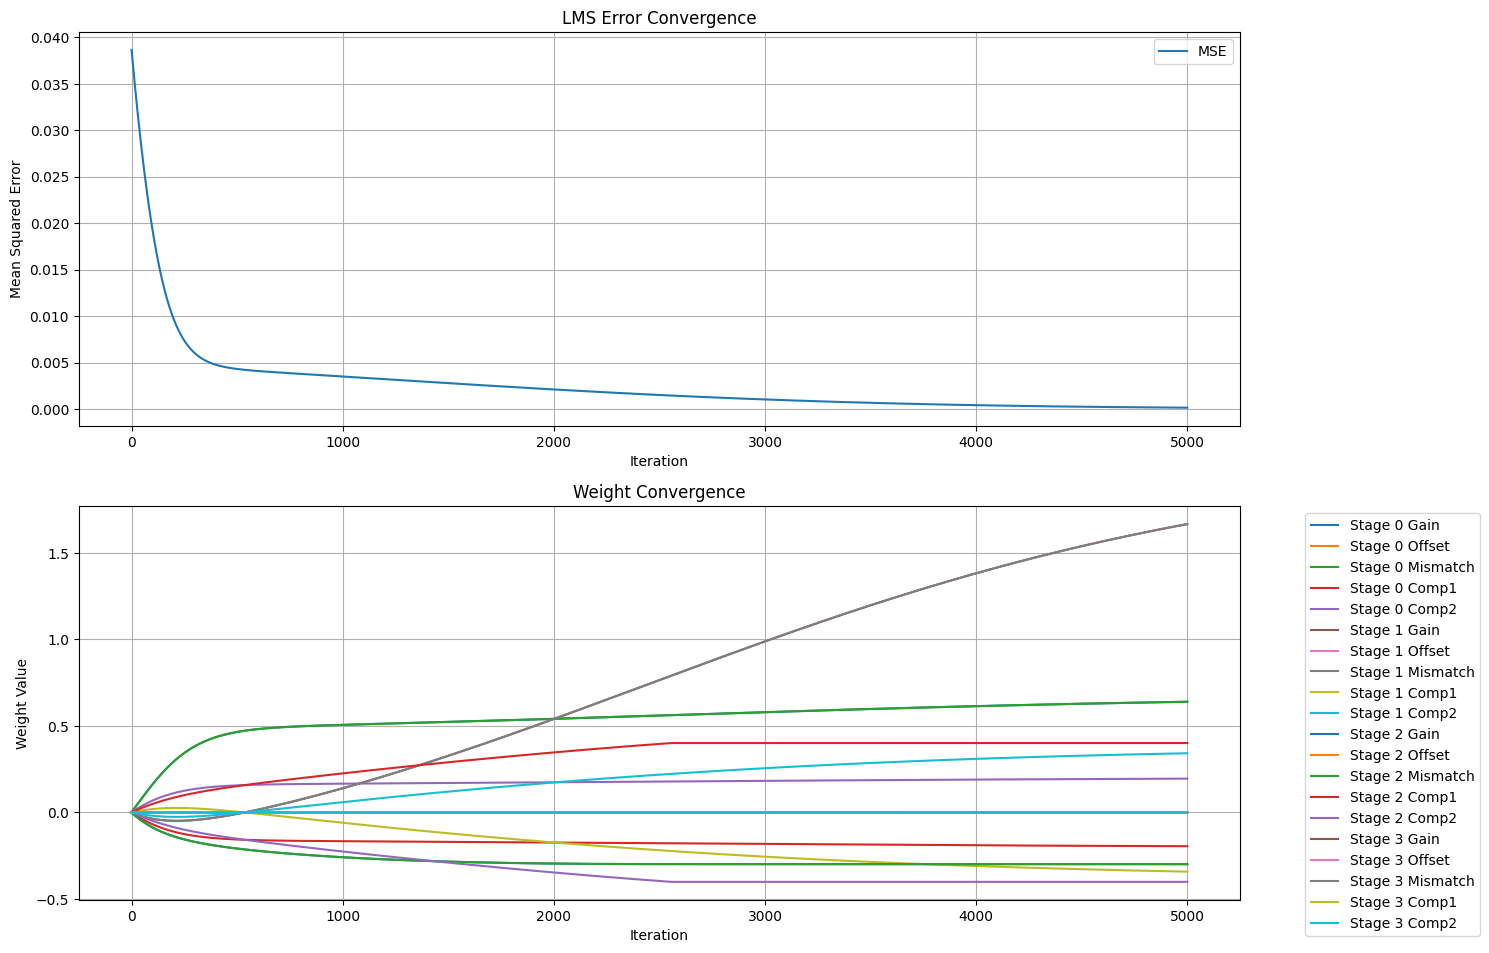

Final SNDR: 29.05 dB


StopIteration: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
A = Vfs / 2 * 0.95
x = A * np.sin(2 * np.pi * f_in * t)

# MDAC with Errors
def mdac_stage(v_in, v_ref=1.0, A0=1000, offset_ota=0.01, cap_mismatch=0.02, comp_offset=0.01):
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2
    G_ideal = 4
    G_eff = G_ideal / (1 + G_ideal / A0) * (1 + cap_mismatch)
    v_res = G_eff * (v_in - dac_out) + offset_ota
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC with Calibration
def pipeline_adc(x, v_ref=1.0, weights=None):
    if weights is None:
        weights = np.zeros((n_stages, 5))
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d, v_res[i] = mdac_stage(residue[i], v_ref,
                                     A0=1000 if stage < 4 else 1e6,  # Errors in stages 0-3
                                     offset_ota=0.01 if stage < 4 else 0,
                                     cap_mismatch=0.02 if stage < 4 else 0,
                                     comp_offset=0.01 if stage < 4 else 0)
            if stage < 4:
                d += (weights[stage, 0] * d + weights[stage, 1] +
                      weights[stage, 2] * d + weights[stage, 3] * (d < 0) +
                      weights[stage, 4] * (d > 0))
            d_stage[i] = d
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Ideal 16-bit ADC
def ideal_adc(x, bits=16, v_ref=1.0):
    lsb = v_ref / (2 ** bits)
    return np.round(x / lsb) * lsb - v_ref / 2

# LMS Calibration with Tracking
n_iterations = 5000
mu = 0.01
weights = np.zeros((4, 5))  # 4 stages, 5 weights each
errors = []
sndr_history = []
weights_history = [np.zeros((4, 5)) for _ in range(n_iterations)]
ref_output = ideal_adc(x)

for iter in range(n_iterations):
    adc_output, digital_outputs = pipeline_adc(x, Vfs, weights)
    error = ref_output - adc_output
    errors.append(np.mean(error ** 2))
    signal_power = np.mean(x ** 2)
    noise_dist_power = np.mean(error ** 2)
    sndr = 10 * np.log10(signal_power / noise_dist_power)
    sndr_history.append(sndr)

    # Update weights
    for stage in range(4):
        d = digital_outputs[:, stage]
        weights[stage, 0] += mu * np.mean(error * d)  # Gain
        weights[stage, 1] += mu * np.mean(error)  # Offset
        weights[stage, 2] += mu * np.mean(error * d)  # Mismatch
        weights[stage, 3] += mu * np.mean(error * (d < 0))  # Comp threshold 1
        weights[stage, 4] += mu * np.mean(error * (d > 0))  # Comp threshold 2
    weights_history[iter] = weights.copy()

# Plotting
plt.figure(figsize=(15, 10))

# Error vs Iteration
plt.subplot(2, 1, 1)
plt.plot(errors, label="MSE")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("LMS Error Convergence")
plt.grid()
plt.legend()

# Weights vs Iteration
plt.subplot(2, 1, 2)
for stage in range(4):
    for i, label in enumerate(["Gain", "Offset", "Mismatch", "Comp1", "Comp2"]):
        plt.plot([w[stage, i] for w in weights_history],
                 label=f"Stage {stage} {label}")
plt.xlabel("Iteration")
plt.ylabel("Weight Value")
plt.title("Weight Convergence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

# Final Results
print(f"Final SNDR: {sndr_history[-1]:.2f} dB")
print(f"Iterations for SNDR > 95 dB: {next(i for i, s in enumerate(sndr_history) if s > 95)}")
print("Final Weights:")
for stage in range(4):
    print(f"Stage {stage}: {weights[stage]}")

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
A = Vfs / 2 * 0.95
x = A * np.sin(2 * np.pi * f_in * t)

# MDAC with Errors
def mdac_stage(v_in, v_ref=1.0, A0=1000, offset_ota=0.01, cap_mismatch=0.02, comp_offset=0.01):
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2
    G_ideal = 4
    G_eff = G_ideal / (1 + G_ideal / A0) * (1 + cap_mismatch)
    v_res = G_eff * (v_in - dac_out) + offset_ota
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC with Calibration
def pipeline_adc(x, v_ref=1.0, weights=None):
    if weights is None:
        weights = np.zeros((n_stages, 5))
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d, v_res[i] = mdac_stage(residue[i], v_ref,
                                     A0=1000 if stage < 4 else 1e6,
                                     offset_ota=0.01 if stage < 4 else 0,
                                     cap_mismatch=0.02 if stage < 4 else 0,
                                     comp_offset=0.01 if stage < 4 else 0)
            if stage < 4:
                d += (weights[stage, 0] * d + weights[stage, 1] +
                      weights[stage, 2] * d + weights[stage, 3] * (d < 0) +
                      weights[stage, 4] * (d > 0))
            d_stage[i] = d
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Ideal 16-bit ADC
def ideal_adc(x, bits=16, v_ref=1.0):
    lsb = v_ref / (2 ** bits)
    return np.round(x / lsb) * lsb - v_ref / 2

# NLMS Calibration
n_iterations = 5000
mu = 0.1  # Step size for NLMS (typically larger than LMS)
epsilon = 1e-6  # Small constant for normalization
weights = np.zeros((4, 5))  # 4 stages, 5 weights each
errors = []
sndr_history = []
weights_history = [np.zeros((4, 5)) for _ in range(n_iterations)]
ref_output = ideal_adc(x)

for iter in range(n_iterations):
    adc_output, digital_outputs = pipeline_adc(x, Vfs, weights)
    error = ref_output - adc_output
    errors.append(np.mean(error ** 2))
    signal_power = np.mean(x ** 2)
    noise_dist_power = np.mean(error ** 2)
    sndr = 10 * np.log10(signal_power / noise_dist_power)
    sndr_history.append(sndr)

    # NLMS Update
    for stage in range(4):
        d = digital_outputs[:, stage]
        input_power = np.mean(d ** 2) + epsilon  # Normalize by input power
        weights[stage, 0] += (mu / input_power) * np.mean(error * d)  # Gain
        weights[stage, 1] += (mu / epsilon) * np.mean(error)  # Offset (no input dependency)
        weights[stage, 2] += (mu / input_power) * np.mean(error * d)  # Mismatch
        weights[stage, 3] += (mu / input_power) * np.mean(error * (d < 0))  # Comp1
        weights[stage, 4] += (mu / input_power) * np.mean(error * (d > 0))  # Comp2
    weights_history[iter] = weights.copy()

# Plotting
plt.figure(figsize=(15, 10))

# Error vs Iteration
plt.subplot(2, 1, 1)
plt.plot(errors, label="MSE")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("NLMS Error Convergence")
plt.grid()
plt.legend()

# Weights vs Iteration
plt.subplot(2, 1, 2)
for stage in range(4):
    for i, label in enumerate(["Gain", "Offset", "Mismatch", "Comp1", "Comp2"]):
        plt.plot([w[stage, i] for w in weights_history],
                 label=f"Stage {stage} {label}")
plt.xlabel("Iteration")
plt.ylabel("Weight Value")
plt.title("NLMS Weight Convergence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

# Results
iterations_to_95db = next((i for i, s in enumerate(sndr_history) if s > 95), n_iterations)
print(f"Final SNDR: {sndr_history[-1]:.2f} dB")
print(f"Iterations for SNDR > 95 dB: {iterations_to_95db}")
print("Final Weights:")
for stage in range(4):
    print(f"Stage {stage}: {weights[stage]}")

<ipython-input-16-82902d0ee7aa>:82: RuntimeWarning: overflow encountered in square
  errors.append(np.mean(error ** 2))
<ipython-input-16-82902d0ee7aa>:84: RuntimeWarning: overflow encountered in square
  noise_dist_power = np.mean(error ** 2)
<ipython-input-16-82902d0ee7aa>:85: RuntimeWarning: divide by zero encountered in log10
  sndr = 10 * np.log10(signal_power / noise_dist_power)
<ipython-input-16-82902d0ee7aa>:91: RuntimeWarning: overflow encountered in square
  input_power = np.mean(d ** 2) + epsilon  # Normalize by input power
<ipython-input-16-82902d0ee7aa>:92: RuntimeWarning: overflow encountered in multiply
  weights[stage, 0] += (mu / input_power) * np.mean(error * d)  # Gain
<ipython-input-16-82902d0ee7aa>:92: RuntimeWarning: invalid value encountered in scalar multiply
  weights[stage, 0] += (mu / input_power) * np.mean(error * d)  # Gain
<ipython-input-16-82902d0ee7aa>:94: RuntimeWarning: overflow encountered in multiply
  weights[stage, 2] += (mu / input_power) * np.mea

KeyboardInterrupt: 

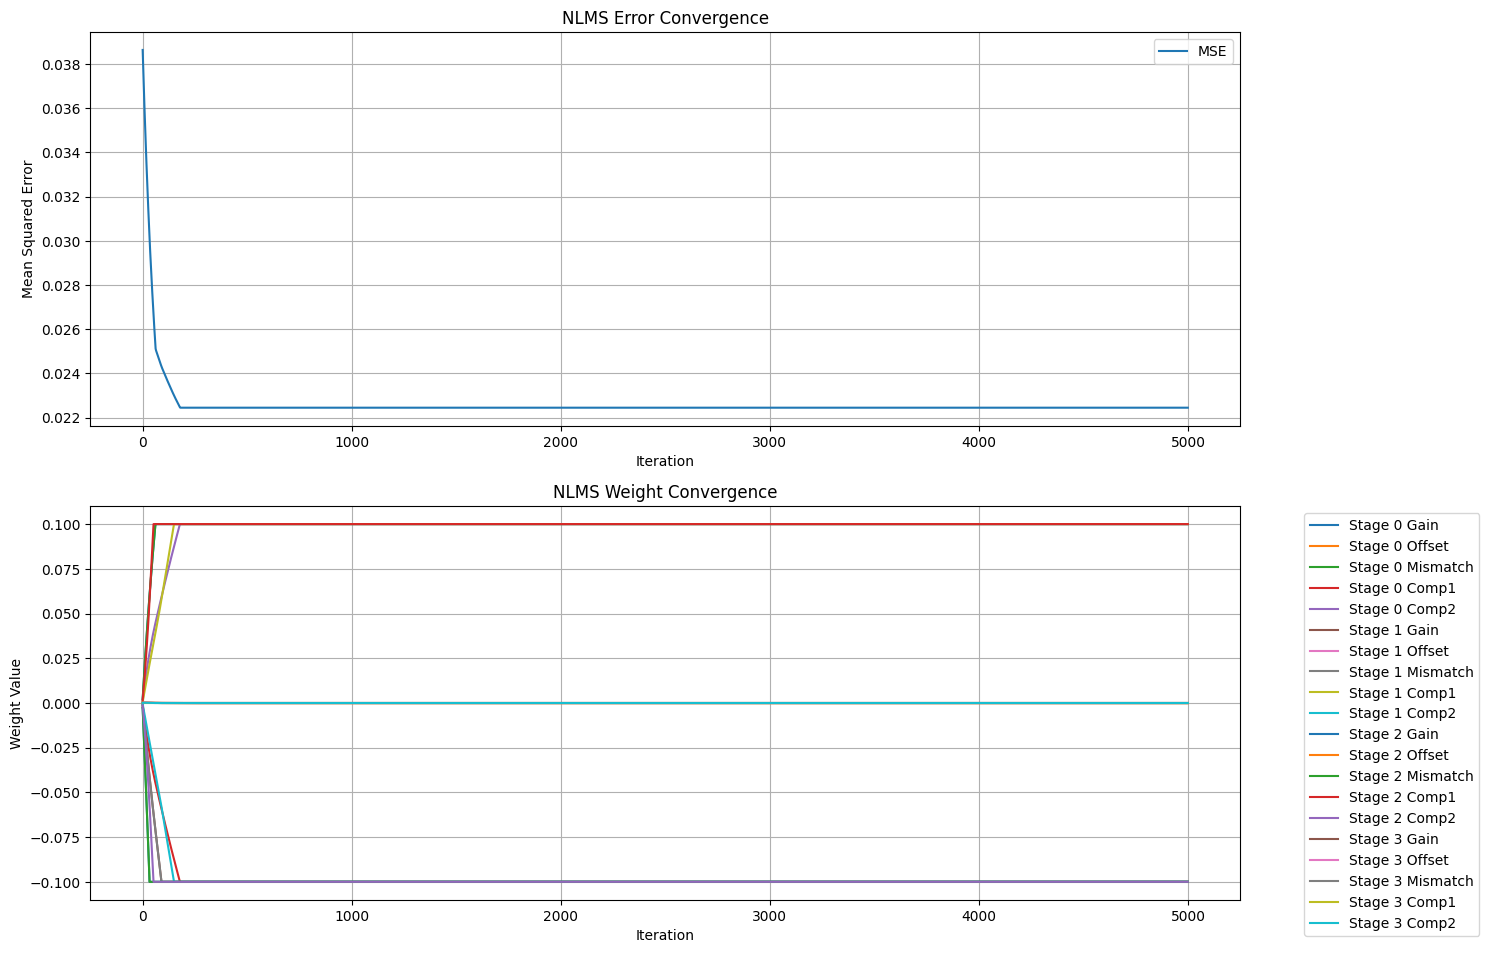

Final SNDR: 7.01 dB
Iterations for SNDR > 95 dB: 5000
Final Weights:
Stage 0: [ 1.00000000e-01 -6.39395884e-05  1.00000000e-01 -1.00000000e-01
  1.00000000e-01]
Stage 1: [-1.00000000e-01 -6.39395884e-05 -1.00000000e-01  1.00000000e-01
 -1.00000000e-01]
Stage 2: [-1.00000000e-01 -6.39395884e-05 -1.00000000e-01  1.00000000e-01
 -1.00000000e-01]
Stage 3: [-8.23732765e-10 -6.39395884e-05 -8.23732765e-10 -6.39388419e-05
 -4.72292223e-05]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
A = Vfs / 2 * 0.95
x = A * np.sin(2 * np.pi * f_in * t)

# MDAC with Errors
def mdac_stage(v_in, v_ref=1.0, A0=1000, offset_ota=0.01, cap_mismatch=0.02, comp_offset=0.01):
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2
    G_ideal = 4
    G_eff = G_ideal / (1 + G_ideal / A0) * (1 + cap_mismatch)
    v_res = G_eff * (v_in - dac_out) + offset_ota
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC with Calibration
def pipeline_adc(x, v_ref=1.0, weights=None):
    if weights is None:
        weights = np.zeros((n_stages, 5))
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d, v_res[i] = mdac_stage(residue[i], v_ref,
                                     A0=1000 if stage < 4 else 1e6,
                                     offset_ota=0.01 if stage < 4 else 0,
                                     cap_mismatch=0.02 if stage < 4 else 0,
                                     comp_offset=0.01 if stage < 4 else 0)
            if stage < 4:
                correction = (weights[stage, 0] * d + weights[stage, 1] +
                              weights[stage, 2] * d + weights[stage, 3] * (d < 0) +
                              weights[stage, 4] * (d > 0))
                d += np.clip(correction, -1, 1)  # Clip correction
            d_stage[i] = d
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Ideal 16-bit ADC
def ideal_adc(x, bits=16, v_ref=1.0):
    lsb = v_ref / (2 ** bits)
    return np.round(x / lsb) * lsb - v_ref / 2

# NLMS Calibration
n_iterations = 5000
mu = 0.01  # Reduced step size
epsilon = 0.01  # Increased to prevent division issues
weights = np.zeros((4, 5))
errors = []
sndr_history = []
weights_history = [np.zeros((4, 5)) for _ in range(n_iterations)]
ref_output = ideal_adc(x)

for iter in range(n_iterations):
    adc_output, digital_outputs = pipeline_adc(x, Vfs, weights)
    error = ref_output - adc_output
    errors.append(np.mean(error ** 2))
    signal_power = np.mean(x ** 2)
    noise_dist_power = np.mean(error ** 2)
    sndr = 10 * np.log10(signal_power / noise_dist_power)
    sndr_history.append(sndr if np.isfinite(sndr) else -np.inf)

    # NLMS Update
    for stage in range(4):
        d = digital_outputs[:, stage]
        input_power = np.mean(d ** 2) + epsilon
        weights[stage, 0] += (mu / input_power) * np.mean(error * d)  # Gain
        weights[stage, 1] += (mu / epsilon) * np.mean(error)  # Offset
        weights[stage, 2] += (mu / input_power) * np.mean(error * d)  # Mismatch
        weights[stage, 3] += (mu / input_power) * np.mean(error * (d < 0))  # Comp1
        weights[stage, 4] += (mu / input_power) * np.mean(error * (d > 0))  # Comp2
        weights[stage] = np.clip(weights[stage], -0.1, 0.1)  # Clip weights
    weights_history[iter] = weights.copy()

# Plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(errors, label="MSE")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("NLMS Error Convergence")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
for stage in range(4):
    for i, label in enumerate(["Gain", "Offset", "Mismatch", "Comp1", "Comp2"]):
        plt.plot([w[stage, i] for w in weights_history], label=f"Stage {stage} {label}")
plt.xlabel("Iteration")
plt.ylabel("Weight Value")
plt.title("NLMS Weight Convergence")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

# Results
iterations_to_95db = next((i for i, s in enumerate(sndr_history) if s > 95), n_iterations)
print(f"Final SNDR: {sndr_history[-1]:.2f} dB")
print(f"Iterations for SNDR > 95 dB: {iterations_to_95db}")
print("Final Weights:")
for stage in range(4):
    print(f"Stage {stage}: {weights[stage]}")

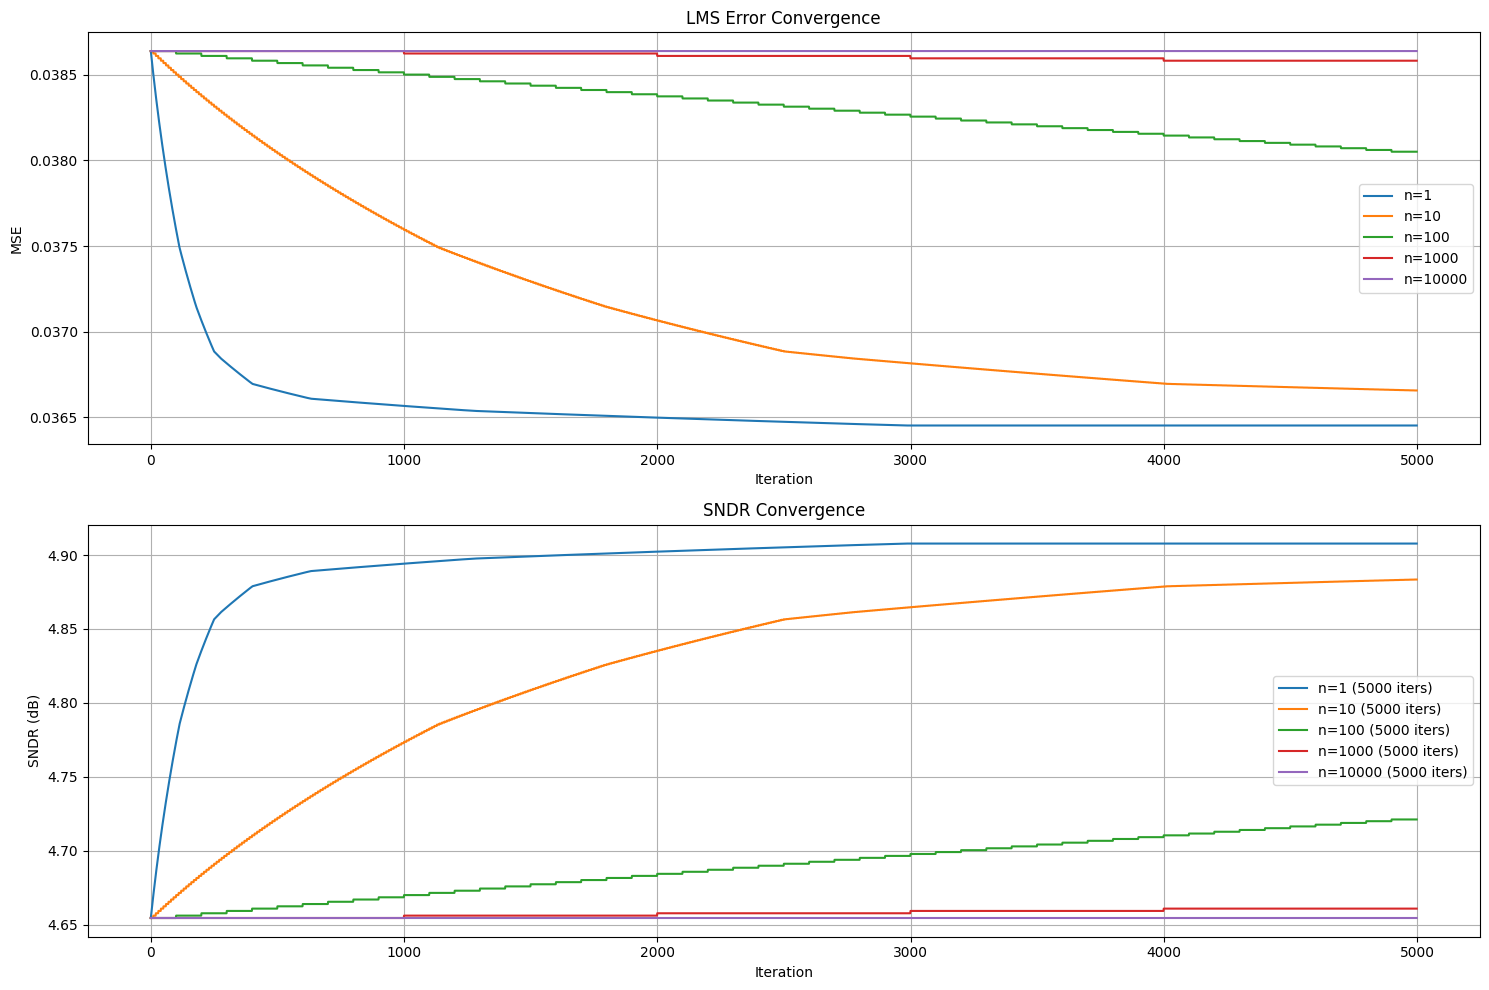

Decimation n=1: Final SNDR = 4.91 dB, Iterations to 95 dB = 5000
Decimation n=10: Final SNDR = 4.88 dB, Iterations to 95 dB = 5000
Decimation n=100: Final SNDR = 4.72 dB, Iterations to 95 dB = 5000
Decimation n=1000: Final SNDR = 4.66 dB, Iterations to 95 dB = 5000
Decimation n=10000: Final SNDR = 4.65 dB, Iterations to 95 dB = 5000


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
f_in = 200e6
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 1024
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
A = Vfs / 2 * 0.95  # 0.475 V

# Input with Noise (SNR = 80 dB)
signal_power = A ** 2 / 2  # 0.225625 V²
noise_power = signal_power / 10 ** (80 / 10)  # 2.25625e-9 V²
noise_std = np.sqrt(noise_power)  # ~4.75e-5 V
x = A * np.sin(2 * np.pi * f_in * t) + np.random.normal(0, noise_std, n_samples)

# MDAC with Nonlinearities and GBW
def mdac_stage(v_in, v_ref=1.0, A0=1000, offset_ota=0.01, cap_mismatch=0.02,
               comp_offset=0.01, gbw=3.277e9):
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2
    G_ideal = 4
    v_res_ideal = G_ideal * (v_in - dac_out)
    # Nonlinear open-loop gain
    v_in_small = v_res_ideal / A0  # Small-signal input to op-amp
    nl_factor = (1 - 0.1 * v_in_small**2 - 0.2 * v_in_small**3 +
                 0.15 * v_in_small**4 + 0.1 * v_in_small**5)
    v_res = A0 * v_in_small * nl_factor / (1 + G_ideal / A0) * (1 + cap_mismatch) + offset_ota
    # Finite GBW effect (simplified settling)
    tau = 1 / (2 * np.pi * gbw)
    settling_factor = 1 - np.exp(-1 / (fs * tau))
    v_res *= settling_factor
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC
def pipeline_adc(x, v_ref=1.0, weights=None):
    if weights is None:
        weights = np.zeros((n_stages, 9))  # 9 weights: gain, offset, mismatch, comp1, comp2, nl2-5
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d, v_res[i] = mdac_stage(residue[i], v_ref,
                                     A0=1000 if stage < 4 else 1e6,
                                     offset_ota=0.01 if stage < 4 else 0,
                                     cap_mismatch=0.02 if stage < 4 else 0,
                                     comp_offset=0.01 if stage < 4 else 0)
            if stage < 4:
                d += (weights[stage, 0] * d + weights[stage, 1] + weights[stage, 2] * d +
                      weights[stage, 3] * (d < 0) + weights[stage, 4] * (d > 0) +
                      weights[stage, 5] * d**2 + weights[stage, 6] * d**3 +
                      weights[stage, 7] * d**4 + weights[stage, 8] * d**5)
                d = np.clip(d, -1, 1)
            d_stage[i] = d
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Ideal 16-bit ADC
def ideal_adc(x, bits=16, v_ref=1.0):
    lsb = v_ref / (2 ** bits)
    return np.round(x / lsb) * lsb - v_ref / 2

# LMS Calibration with Decimation
def run_lms(decimation_factor=1):
    n_iterations = 5000
    mu = 0.01
    weights = np.zeros((4, 9))
    errors = []
    sndr_history = []
    weights_history = [np.zeros((4, 9)) for _ in range(n_iterations)]
    ref_output = ideal_adc(x)

    for iter in range(n_iterations):
        if iter % decimation_factor == 0:  # Process every n-th iteration
            adc_output, digital_outputs = pipeline_adc(x, Vfs, weights)
            error = ref_output - adc_output
            errors.append(np.mean(error ** 2))
            signal_power = np.mean(x ** 2)
            noise_dist_power = np.mean(error ** 2)
            sndr = 10 * np.log10(signal_power / noise_dist_power)
            sndr_history.append(sndr if np.isfinite(sndr) else -np.inf)

            for stage in range(4):
                d = digital_outputs[:, stage]
                weights[stage, 0] += mu * np.mean(error * d)  # Gain
                weights[stage, 1] += mu * np.mean(error)  # Offset
                weights[stage, 2] += mu * np.mean(error * d)  # Mismatch
                weights[stage, 3] += mu * np.mean(error * (d < 0))  # Comp1
                weights[stage, 4] += mu * np.mean(error * (d > 0))  # Comp2
                weights[stage, 5] += mu * np.mean(error * d**2)  # 2nd order
                weights[stage, 6] += mu * np.mean(error * d**3)  # 3rd order
                weights[stage, 7] += mu * np.mean(error * d**4)  # 4th order
                weights[stage, 8] += mu * np.mean(error * d**5)  # 5th order
                weights[stage] = np.clip(weights[stage], -0.1, 0.1)
            weights_history[iter] = weights.copy()
        else:
            errors.append(errors[-1])
            sndr_history.append(sndr_history[-1])
            weights_history[iter] = weights_history[iter-1]

    return errors, sndr_history, weights_history

# Test Decimation Factors
decimation_factors = [1, 10, 100, 1000, 10000]
results = {}
for n in decimation_factors:
    errors, sndr_history, weights_history = run_lms(n)
    iterations_to_95db = next((i for i, s in enumerate(sndr_history) if s > 95), n_iterations)
    results[n] = (errors, sndr_history, iterations_to_95db)

# Plotting
plt.figure(figsize=(15, 10))
for n, (errors, sndr_history, iters) in results.items():
    plt.subplot(2, 1, 1)
    plt.plot(errors, label=f"n={n}")
    plt.subplot(2, 1, 2)
    plt.plot(sndr_history, label=f"n={n} ({iters} iters)")
plt.subplot(2, 1, 1)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("LMS Error Convergence")
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.xlabel("Iteration")
plt.ylabel("SNDR (dB)")
plt.title("SNDR Convergence")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Results
for n, (_, sndr_history, iters) in results.items():
    print(f"Decimation n={n}: Final SNDR = {sndr_history[-1]:.2f} dB, Iterations to 95 dB = {iters}")

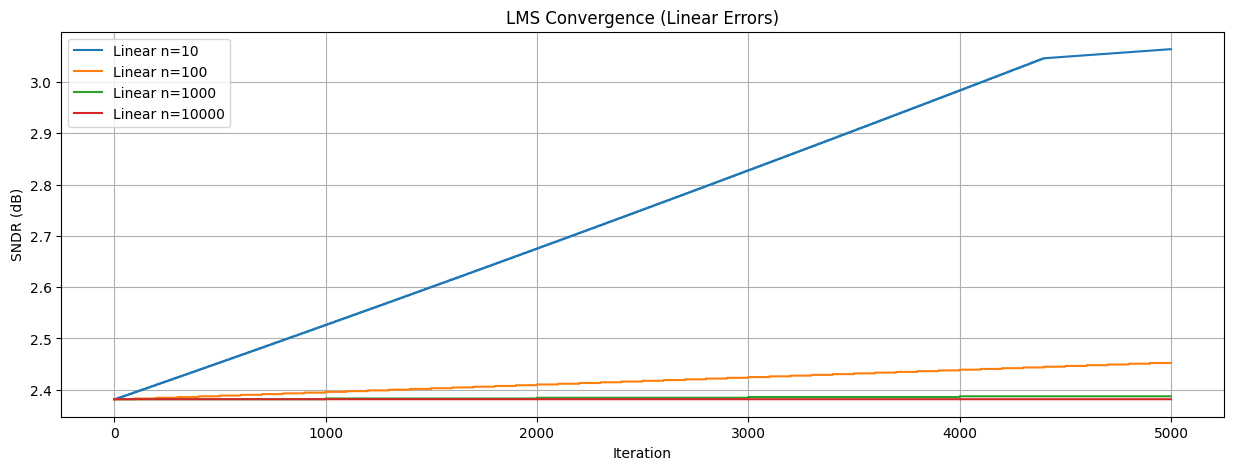

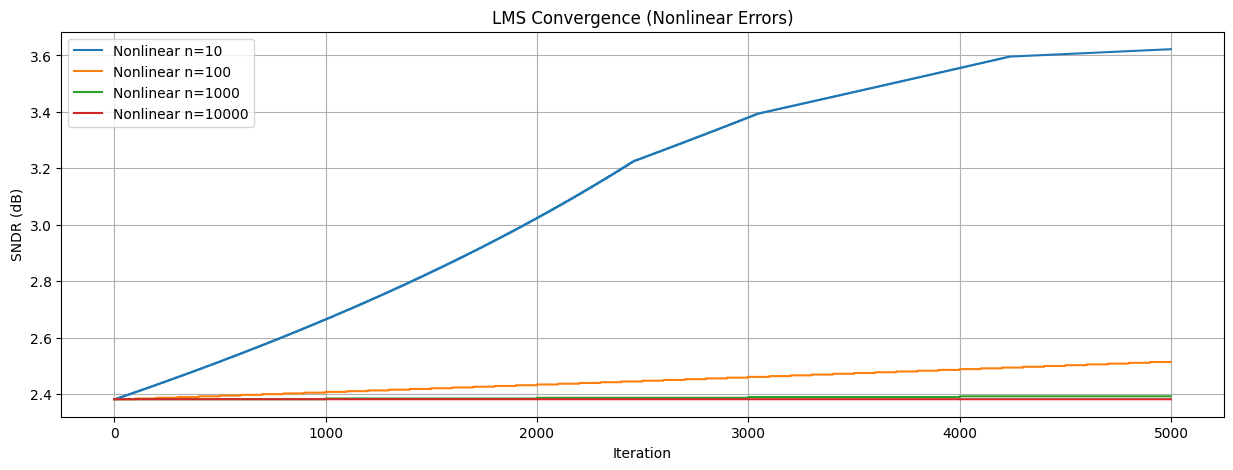

Ideal Case: MSE = 3.375 BER = 0.84375

Linear Errors:
n=10: Final SNDR = 3.06 dB, Iterations to 95 dB = 5000, MSE = 3.3438, BER = 0.8359
n=100: Final SNDR = 2.45 dB, Iterations to 95 dB = 5000, MSE = 3.3750, BER = 0.8438
n=1000: Final SNDR = 2.39 dB, Iterations to 95 dB = 5000, MSE = 3.3750, BER = 0.8438
n=10000: Final SNDR = 2.38 dB, Iterations to 95 dB = 5000, MSE = 3.3750, BER = 0.8438

Nonlinear Errors:
n=10: Final SNDR = 3.62 dB, Iterations to 95 dB = 5000, MSE = 3.2812, BER = 0.8203
n=100: Final SNDR = 2.51 dB, Iterations to 95 dB = 5000, MSE = 3.4062, BER = 0.8516
n=1000: Final SNDR = 2.39 dB, Iterations to 95 dB = 5000, MSE = 3.3750, BER = 0.8438
n=10000: Final SNDR = 2.38 dB, Iterations to 95 dB = 5000, MSE = 3.3750, BER = 0.8438


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 500e6
bw = 200e6
n_tones = 128
Vfs = 1.0
n_bits = 13
n_stages = 6
bits_per_stage = 2.5
n_samples = 318  # DFT points
t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
delta_f = bw / (n_tones - 1)
f_tones = np.arange(n_tones) * delta_f

# Multitone BPSK Signal
symbols = np.random.choice([1, -1], n_tones)  # BPSK symbols
x_ideal = np.zeros(n_samples)
for k in range(n_tones):
    x_ideal += (Vfs / n_tones) * np.cos(2 * np.pi * f_tones[k] * t + symbols[k] * np.pi / 2)
x_ideal = np.clip(x_ideal, -Vfs/2, Vfs/2)

# MDAC Stage
def mdac_stage(v_in, v_ref=1.0, A0=1000, offset_ota=0.01, cap_mismatch=0.02,
               comp_offset=0.01, gbw=None, nonlinear=False):
    thresholds = [-v_ref/4 + comp_offset, v_ref/4 + comp_offset]
    if v_in < thresholds[0]:
        d = -1
        dac_out = -v_ref/2
    elif v_in < thresholds[1]:
        d = 0
        dac_out = 0
    else:
        d = 1
        dac_out = v_ref/2
    G_ideal = 4
    v_res_ideal = G_ideal * (v_in - dac_out)
    if nonlinear:
        v_in_small = v_res_ideal / A0
        nl_factor = (1 - 0.1 * v_in_small**2 - 0.2 * v_in_small**3 +
                     0.15 * v_in_small**4 + 0.1 * v_in_small**5)
        v_res = A0 * v_in_small * nl_factor / (1 + G_ideal / A0) * (1 + cap_mismatch) + offset_ota
        tau = 1 / (2 * np.pi * gbw)
        settling_factor = 1 - np.exp(-1 / (fs * tau))
        v_res *= settling_factor
    else:
        v_res = G_ideal / (1 + G_ideal / A0) * (1 + cap_mismatch) * (v_in - dac_out) + offset_ota
    v_res = np.clip(v_res, -v_ref/2, v_ref/2)
    return d, v_res

# Pipeline ADC
def pipeline_adc(x, v_ref=1.0, weights=None, nonlinear=False):
    n_weights = 9 if nonlinear else 5
    if weights is None:
        weights = np.zeros((n_stages, n_weights))
    digital_outputs = np.zeros((len(x), n_stages))
    residue = x.copy()
    for stage in range(n_stages):
        d_stage = np.zeros(len(x))
        v_res = np.zeros(len(x))
        for i in range(len(x)):
            d, v_res[i] = mdac_stage(residue[i], v_ref,
                                     A0=1000 if stage < 4 else 1e6,
                                     offset_ota=0.01 if stage < 4 else 0,
                                     cap_mismatch=0.02 if stage < 4 else 0,
                                     comp_offset=0.01 if stage < 4 else 0,
                                     gbw=3.277e9 if nonlinear and stage < 4 else None,
                                     nonlinear=nonlinear and stage < 4)
            if stage < 4:
                correction = (weights[stage, 0] * d + weights[stage, 1] +
                              weights[stage, 2] * d + weights[stage, 3] * (d < 0) +
                              weights[stage, 4] * (d > 0))
                if nonlinear:
                    correction += (weights[stage, 5] * d**2 + weights[stage, 6] * d**3 +
                                   weights[stage, 7] * d**4 + weights[stage, 8] * d**5)
                d += np.clip(correction, -1, 1)
            d_stage[i] = d
        digital_outputs[:, stage] = d_stage
        residue = v_res
    digital_word = np.zeros(len(x))
    for stage in range(n_stages):
        shift = n_bits - (stage + 1) * bits_per_stage
        digital_word += digital_outputs[:, stage] * (2 ** max(0, shift))
    lsb = v_ref / (2 ** n_bits)
    adc_output = digital_word * lsb - v_ref / 2
    return adc_output, digital_outputs

# Ideal 16-bit ADC
def ideal_adc(x, bits=16, v_ref=1.0):
    lsb = v_ref / (2 ** bits)
    return np.round(x / lsb) * lsb - v_ref / 2

# DFT and Symbol Estimation
def estimate_symbols(adc_output):
    dft = np.fft.fft(adc_output, n_samples) / n_samples
    est_symbols = np.zeros(n_tones)
    for k in range(n_tones):
        bin_idx = int(np.round(f_tones[k] * n_samples / fs))
        phase = np.angle(dft[bin_idx])
        est_symbols[k] = 1 if phase > -np.pi/2 and phase < np.pi/2 else -1
    return est_symbols

# LMS Calibration
def run_lms(decimation_factor=1, nonlinear=False):
    n_iterations = 5000
    mu = 0.01
    n_weights = 9 if nonlinear else 5
    weights = np.zeros((4, n_weights))
    sndr_history = []
    ref_output = ideal_adc(x_ideal)

    for iter in range(n_iterations):
        if iter % decimation_factor == 0:
            adc_output, digital_outputs = pipeline_adc(x_ideal, Vfs, weights, nonlinear)
            error = ref_output - adc_output
            signal_power = np.mean(x_ideal ** 2)
            noise_dist_power = np.mean(error ** 2)
            sndr = 10 * np.log10(signal_power / noise_dist_power)
            sndr_history.append(sndr if np.isfinite(sndr) else -np.inf)

            for stage in range(4):
                d = digital_outputs[:, stage]
                weights[stage, 0] += mu * np.mean(error * d)
                weights[stage, 1] += mu * np.mean(error)
                weights[stage, 2] += mu * np.mean(error * d)
                weights[stage, 3] += mu * np.mean(error * (d < 0))
                weights[stage, 4] += mu * np.mean(error * (d > 0))
                if nonlinear:
                    weights[stage, 5] += mu * np.mean(error * d**2)
                    weights[stage, 6] += mu * np.mean(error * d**3)
                    weights[stage, 7] += mu * np.mean(error * d**4)
                    weights[stage, 8] += mu * np.mean(error * d**5)
                weights[stage] = np.clip(weights[stage], -0.1, 0.1)
        else:
            sndr_history.append(sndr_history[-1])

    # Final DFT and metrics
    adc_output, _ = pipeline_adc(x_ideal, Vfs, weights, nonlinear)
    est_symbols = estimate_symbols(adc_output)
    mse = np.mean((symbols - est_symbols) ** 2)
    ber = np.mean(symbols != est_symbols)
    return sndr_history, mse, ber

# Test Cases
decimation_factors = [10, 100, 1000, 10000]
results_linear = {}
results_nonlinear = {}

for n in decimation_factors:
    sndr_hist_l, mse_l, ber_l = run_lms(n, nonlinear=False)
    results_linear[n] = (sndr_hist_l, mse_l, ber_l)
    sndr_hist_nl, mse_nl, ber_nl = run_lms(n, nonlinear=True)
    results_nonlinear[n] = (sndr_hist_nl, mse_nl, ber_nl)

# Ideal Case (No Errors)
ideal_output, _ = pipeline_adc(x_ideal, Vfs, weights=np.zeros((n_stages, 5)), nonlinear=False)
est_symbols_ideal = estimate_symbols(ideal_output)
mse_ideal = np.mean((symbols - est_symbols_ideal) ** 2)
ber_ideal = np.mean(symbols != est_symbols_ideal)

# Plotting
plt.figure(figsize=(15, 5))
for n, (sndr_hist, _, _) in results_linear.items():
    plt.plot(sndr_hist, label=f"Linear n={n}")
plt.xlabel("Iteration")
plt.ylabel("SNDR (dB)")
plt.title("LMS Convergence (Linear Errors)")
plt.legend()
plt.grid()
plt.figure(figsize=(15, 5))
for n, (sndr_hist, _, _) in results_nonlinear.items():
    plt.plot(sndr_hist, label=f"Nonlinear n={n}")
plt.xlabel("Iteration")
plt.ylabel("SNDR (dB)")
plt.title("LMS Convergence (Nonlinear Errors)")
plt.legend()
plt.grid()
plt.show()

# Results
print("Ideal Case: MSE =", mse_ideal, "BER =", ber_ideal)
print("\nLinear Errors:")
for n, (sndr_hist, mse, ber) in results_linear.items():
    iters = next((i for i, s in enumerate(sndr_hist) if s > 95), 5000)
    print(f"n={n}: Final SNDR = {sndr_hist[-1]:.2f} dB, Iterations to 95 dB = {iters}, MSE = {mse:.4f}, BER = {ber:.4f}")
print("\nNonlinear Errors:")
for n, (sndr_hist, mse, ber) in results_nonlinear.items():
    iters = next((i for i, s in enumerate(sndr_hist) if s > 95), 5000)
    print(f"n={n}: Final SNDR = {sndr_hist[-1]:.2f} dB, Iterations to 95 dB = {iters}, MSE = {mse:.4f}, BER = {ber:.4f}")